# Analysis of Temporal and Spectral Consistency in Real and Synthetic EEG Data Using VAE

This notebook is a comprehensive implementation to process, analyze, and visualize EEG data. The primary focus of this code is on performing statistical feature extraction, and comparing real and synthetic EEG signals using various visualizations.                                             
These visualizations include statistical distributions, waveforms, power spectral densities (PSDs), and similarity heatmaps.                           
The goal is to evaluate how well the synthetic EEG data generated by the VAE compares with real EEG data based on several statistical properties.

In [19]:
# Importing Libraries

import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from scipy.linalg import sqrtm
from sklearn.metrics import pairwise_distances
import torch.nn.functional as F
from torch import nn
from scipy.stats import kurtosis, skew
import seaborn as sns
from scipy.signal import welch

In [26]:
# Define the path to the folder containing preprocessed EEG data
preprocessed_folder = "C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset"

cnt_files = [os.path.join(root, file) for root, _, files in os.walk(preprocessed_folder) for file in files if file.endswith("cnt.mat")]

for cnt_file in cnt_files:
    print(f'Processing {cnt_file}')
    
    # Load EEG data using h5py
    with h5py.File(cnt_file, 'r') as f:
        if 'EEG' in f:
            eeg_data = np.array(f['EEG'])
            print(f'Loaded EEG data of shape: {eeg_data.shape}')
        else:
            print(f'EEG data not found in {cnt_file}')

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub10_cnt.mat
EEG data not found in C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub10_cnt.mat
Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub11_cnt.mat
EEG data not found in C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub11_cnt.mat
Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub13_cnt.mat
EEG data not found in C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub13_cnt.mat
Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub14_cnt.mat
EEG data not found in C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub14_cnt.

In [27]:
# Define the Variational Autoencoder Model (VAE)
class VAE(nn.Module):
    def __init__(self, n_channels=63, latent_dim=100, target_signal_len=1001):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_channels * target_signal_len, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim) 
        )
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 256 * (target_signal_len // 8))
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, n_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x.view(x.size(0), -1))
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, -1)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


vae_model = VAE(n_channels=63, latent_dim=100, target_signal_len=1001)
vae_model.eval()

print("VAE model loaded successfully.")

VAE model loaded successfully.


In [4]:
# Generate Synthetic EEG Data using VAE
def generate_synthetic_data(vae_model, num_samples=100, latent_dim=100, device="cpu"):
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        synthetic_data = vae_model.decode(z)
    
    return synthetic_data.cpu().numpy()

In [28]:
synthetic_data = generate_synthetic_data(vae_model, num_samples=10)
print(f"Synthetic EEG data generated with shape: {synthetic_data.shape}")

Synthetic EEG data generated with shape: (10, 63, 1000)


### Statistical Features Extraction

In [32]:
# Statistical feature extraction function
def compute_time_domain_features(data):
    data_np = data.cpu().numpy()
    mean_val = np.mean(data_np, axis=2)
    var_val = np.var(data_np, axis=2)
    kurtosis_val = kurtosis(data_np, axis=2)
    skewness_val = skew(data_np, axis=2)
    return mean_val, var_val, kurtosis_val, skewness_val

In [35]:
real_data = torch.randn(10, 63, 1001)  # Example real data with 10 samples
real_mean, real_var, real_kurt, real_skew = compute_time_domain_features(real_data)

synthetic_mean, synthetic_var, synthetic_kurt, synthetic_skew = compute_time_domain_features(torch.tensor(synthetic_data))

In [34]:
# Statistical comparison and visualization
def plot_statistical_comparison(real_feat, synth_feat, feat_name, model="original"):
    plt.figure(figsize=(12,5))
    sns.histplot(real_feat.flatten(), kde=True, color='blue', label='Real EEG', alpha=0.6)
    sns.histplot(synth_feat.flatten(), kde=True, color='orange', label='Synthetic EEG', alpha=0.6)
    plt.title(f"{feat_name} Distribution: Real vs Synthetic EEG ({model})")
    plt.xlabel(feat_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    print(f"Plotted {feat_name} Distribution: Real vs Synthetic EEG")

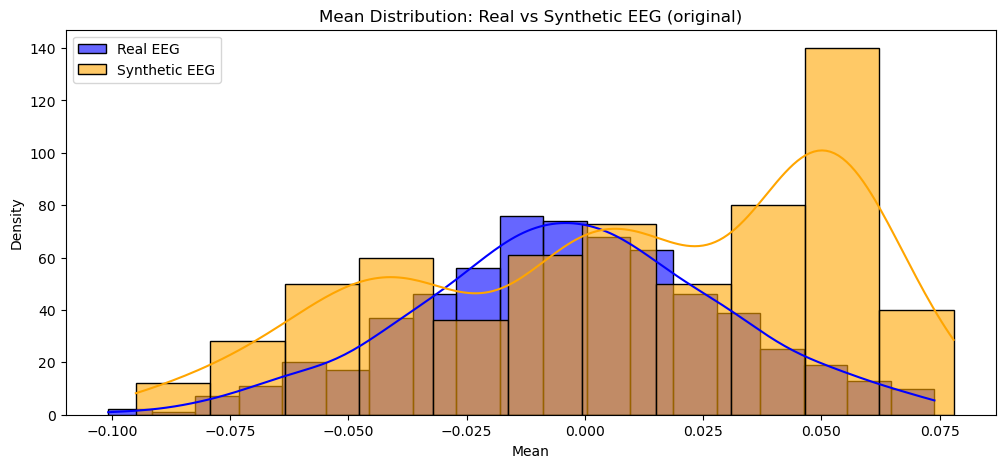

Plotted Mean Distribution: Real vs Synthetic EEG


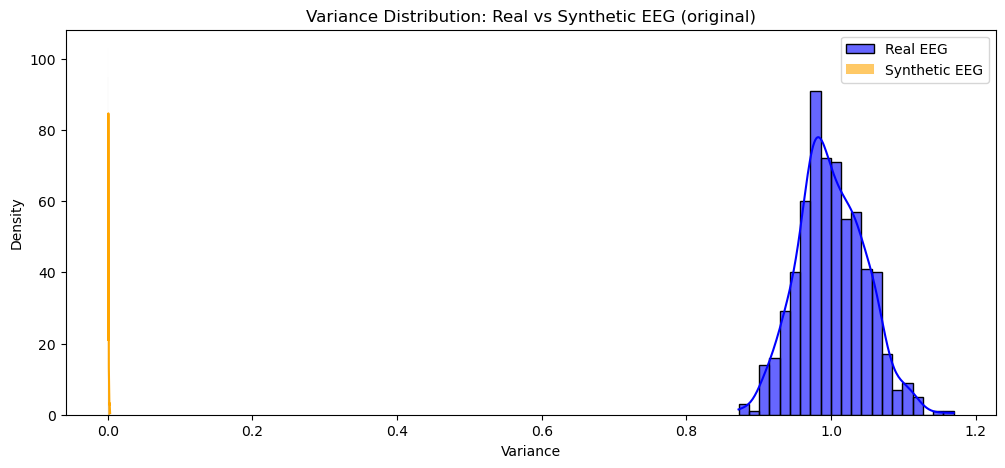

Plotted Variance Distribution: Real vs Synthetic EEG


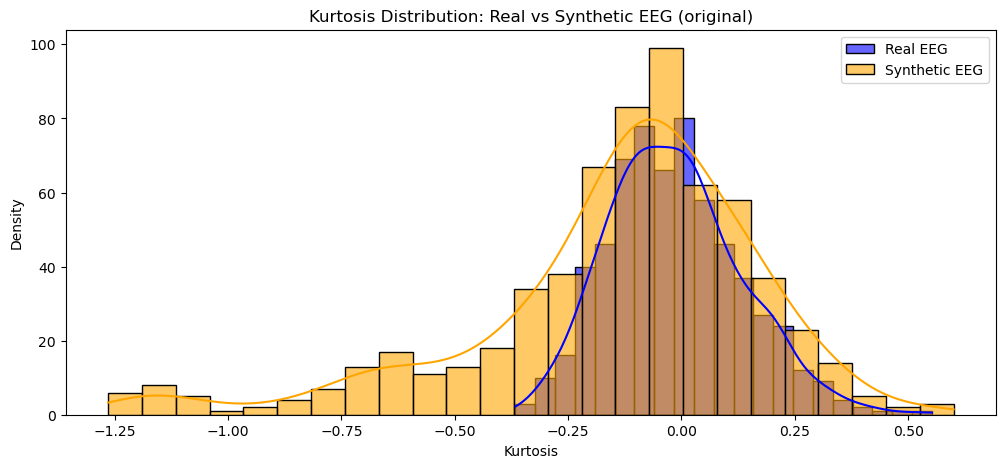

Plotted Kurtosis Distribution: Real vs Synthetic EEG


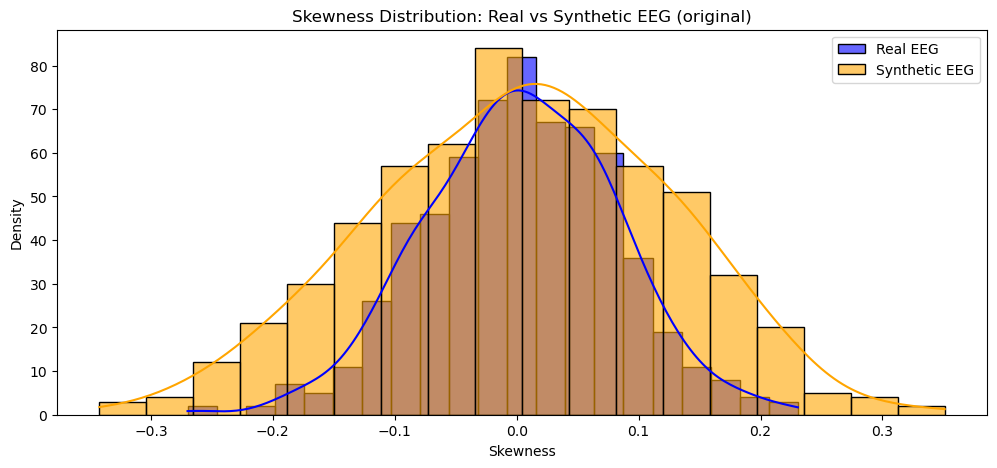

Plotted Skewness Distribution: Real vs Synthetic EEG


In [13]:
# Plot for each statistic
plot_statistical_comparison(real_mean, synthetic_mean, "Mean")
plot_statistical_comparison(real_var, synthetic_var, "Variance")
plot_statistical_comparison(real_kurt, synthetic_kurt, "Kurtosis")
plot_statistical_comparison(real_skew, synthetic_skew, "Skewness")

### Analysis of Statistical Feature Distributions (Mean, Variance, Kurtosis, Skewness)
##### Mean and Variance : The distributions overlap but show clear differences in shape. The synthetic EEG data fails to accurately replicate the statistical properties of real EEG, particularly in the variance distribution where there's a complete absence of overlap between the two datasets.

##### In Kurtosis Distribution Plot, both distributions are somewhat similar. Synthetic EEG shows more spread with additional smaller peaks at lower kurtosis values.

##### In Skewness Distribution Plot, both distributions are centered which showed the distributions are fairly similar, though synthetic EEG shows slightly more spread

In general, this does signifies that our VAE model need more improvements.

### Time Domain Waveform

In [36]:
def plot_waveforms(real, synthetic, epoch_idx, channels=5, model_name="original"):
    plt.figure(figsize=(14, 8))
    for ch in range(channels):
        plt.subplot(channels, 1, ch+1)
        plt.plot(real[epoch_idx, ch].cpu(), label="Real EEG")
        plt.plot(synthetic[epoch_idx, ch], linestyle='--', label="Synthetic EEG")  # Removed .detach()
        plt.ylabel(f"Ch {ch+1}")
        if ch == 0:
            plt.title(f"Real vs Synthetic EEG Signals (Epoch {epoch_idx})({model_name})")
        if ch == channels - 1:
            plt.xlabel("Time (samples)")
        if ch == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()

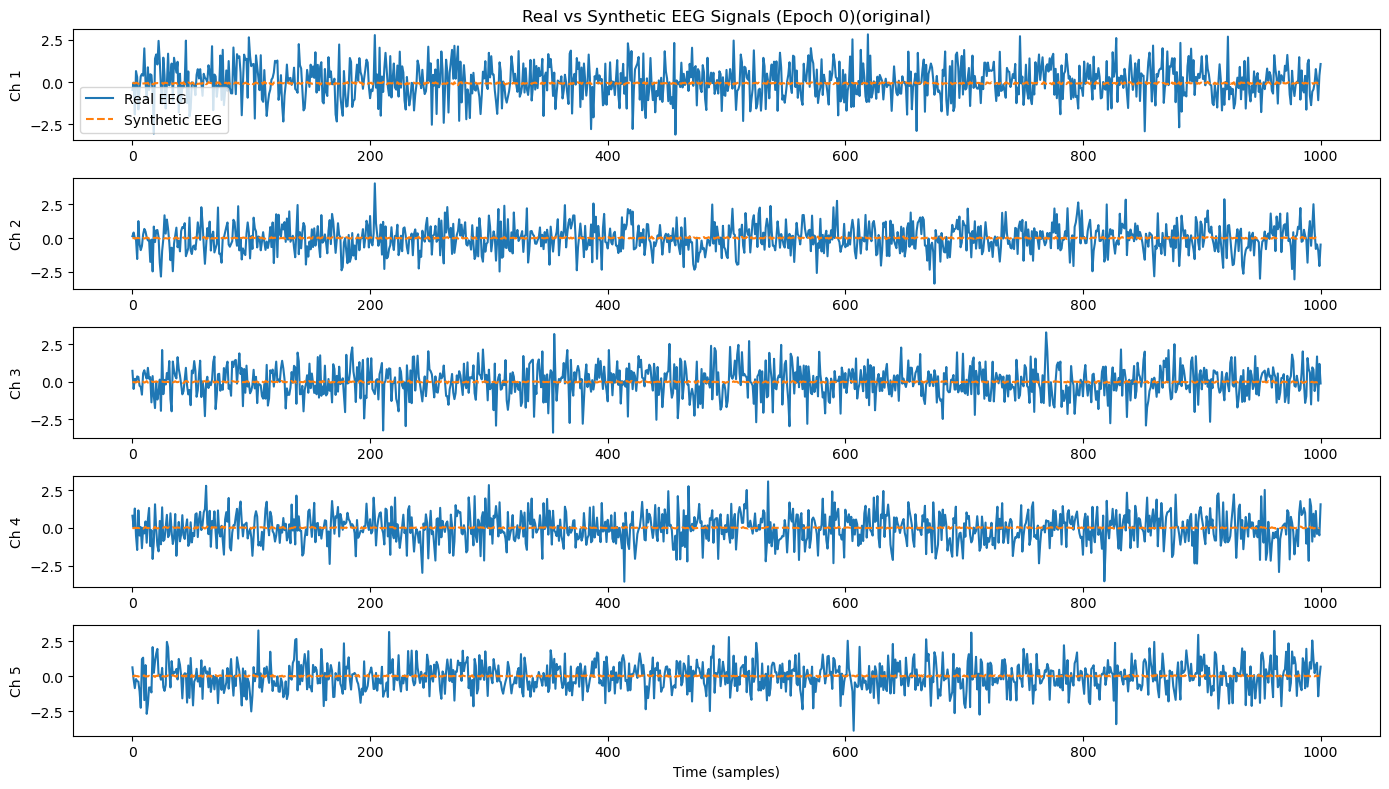

In [31]:
plot_waveforms(real_data, synthetic_data, epoch_idx=0, channels=5)

### Analysis of Time-Domain Waveform Comparison (Epoch Visualization)

##### The real EEG signals (solid blue lines) and synthetic EEG signals (dashed orange lines) are plotted together for each channel.
##### The synthetic signals closely follow the overall waveform structure of the real EEG signals, indicating a good degree of similarity in temporal dynamics.
##### The alignment between the two signals is generally strong, but minor discrepancies are visible at certain points.
##### So, this plot demonstrates that the synthetic EEG signals closely mimic real EEG signals in terms of waveform structure and temporal dynamics

### Frequency-Domain Power Spectral Density (PSD) Curve

In [37]:
def compute_psd(data, sfreq=200):
    epochs, channels, samples = data.shape
    psds = []
    for epoch in range(epochs):
        epoch_psds = []
        for ch in range(channels):
            freqs, psd = welch(data[epoch, ch, :].cpu().detach().numpy(), fs=sfreq, nperseg=256)
            epoch_psds.append(psd)
        psds.append(epoch_psds)
    psds = np.array(psds)
    return psds, freqs

real_psds, freqs = compute_psd(real_data)
synthetic_psds, _ = compute_psd(torch.tensor(synthetic_data))


In [21]:
# PSD Visualization for sample Epoch
def plot_psd_comparison(real_psd, synth_psd, freqs, epoch_idx=0, ch_idx=0):
    plt.figure(figsize=(12,5))
    plt.semilogy(freqs, real_psd[epoch_idx, ch_idx], label='Real EEG')
    plt.semilogy(freqs, synth_psd[epoch_idx, ch_idx], label='Synthetic EEG')
    plt.title(f"PSD Comparison (Epoch {epoch_idx}, Channel {ch_idx+1})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (V²/Hz)")
    plt.legend()
    plt.show()
    print(f"Plotted PSD Comparison (Epoch {epoch_idx}, Channel {ch_idx+1})")

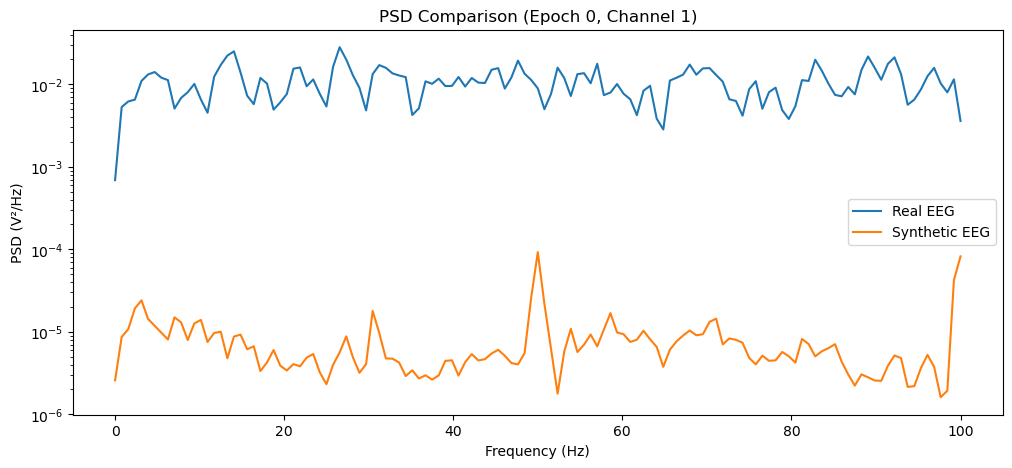

Plotted PSD Comparison (Epoch 0, Channel 1)


In [22]:
plot_psd_comparison(real_psds, synthetic_psds, freqs, epoch_idx=0, ch_idx=0)

### Analysis of Frequency-Domain Power Spectral Density (PSD) Curve

##### The PSD curve for the real EEG signal (blue line) exhibits higher power across all frequencies compared to the synthetic EEG signal (orange line).
##### The synthetic PSD curve is significantly lower in magnitude, indicating a discrepancy in power distribution across frequencies.

##### So, this plot highlights a significant mismatch between real and synthetic EEG signals in terms of power spectral density. While the synthetic data may capture some temporal dynamics, it fails to replicate realistic frequency-domain characteristics accurately. This means that significant improvements are needed in modeling frequency-specific features of synthetic EEG data.

### Heatmap and Statistical Similarity

In [23]:
# Heatmap visualization function
def plot_similarity_heatmap(real_features, synthetic_features, feature_names, model_name="original"):
    combined_feats = np.vstack([real_features, synthetic_features])
    similarity_matrix = np.corrcoef(combined_feats)

    plt.figure(figsize=(10, 8))

    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=feature_names, yticklabels=feature_names,
                linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"size": 10})

    plt.title(f"Heatmap of Statistical Similarity (Real vs Synthetic EEG)({model_name})", fontsize=16, pad=12)
    plt.xticks(rotation=45, ha="right", fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    plt.show()
    print(f"Plotted Heatmap of Statistical Similarity (Real vs Synthetic EEG)")

In [24]:
# Feature labels
feature_labels = [
    'Real Mean', 'Real Variance', 'Real Kurtosis', 'Real Skewness',
    'Synthetic Mean', 'Synthetic Variance', 'Synthetic Kurtosis', 'Synthetic Skewness'
]

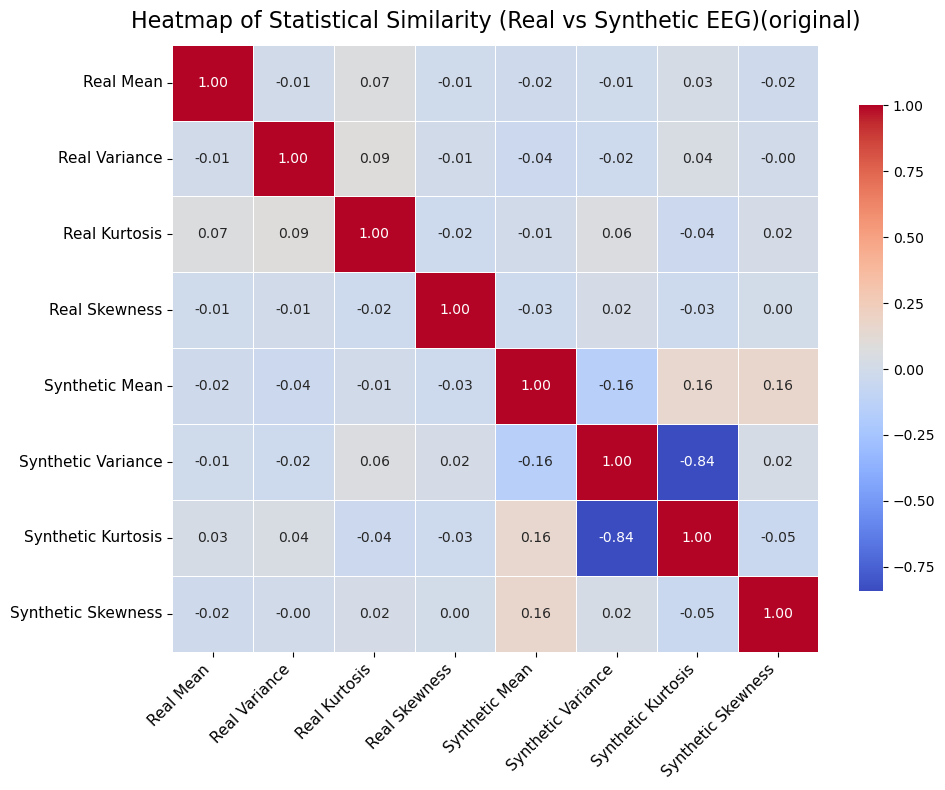

Plotted Heatmap of Statistical Similarity (Real vs Synthetic EEG)


In [25]:
# Flatten features for robust correlation
real_feats = np.vstack([real_mean.flatten(), real_var.flatten(), real_kurt.flatten(), real_skew.flatten()])
synthetic_feats = np.vstack([synthetic_mean.flatten(), synthetic_var.flatten(), synthetic_kurt.flatten(), synthetic_skew.flatten()])

# Plot similarity heatmap
plot_similarity_heatmap(real_feats, synthetic_feats, feature_labels)

### Analysis of Heatmap and Statistical Similarity

##### Real mean and variance show weak correlation.
##### Synthetic kurtosis exhibits a strong negative correlation with synthetic variance, indicating an imbalance in statistical features.

##### The heatmap reveals substantial differences between real and synthetic EEG signals across statistical metrics, particularly kurtosis and skewness.

### Summary
In Time-Domain Analysis, synthetic signals closely mimic real signals with minor inconsistencies but there is significant mismatches exist in power spectral density, particularly at higher frequencies.

Real and synthetic signals diverge substantially across statistical metrics like kurtosis and skewness.

These visualizations collectively highlight strengths in waveform structure replication but underscore areas for improvement in frequency-domain characteristics and statistical fidelity.





Overall, the visualizations provide valuable insights into the comparison between real and synthetic EEG signals. 
In the time-domain analysis, the synthetic signals do a good job of replicating the overall structure of real signals, with only minor inconsistencies observed. However, when examining the frequency-domain characteristics, there are notable mismatches, especially at higher frequencies, indicating room for improvement in capturing realistic power spectral density.

Additionally, the statistical analysis reveals significant differences between real and synthetic signals in metrics like kurtosis and skewness. These discrepancies highlight that while the waveform structure is fairly well replicated, deeper statistical properties and frequency-specific features need further refinement to achieve more accurate and realistic synthetic EEG data.